In [1]:
!pwd

/home/padala.r/MyProject


In [2]:
import os
import glob
import time
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import dask.bag as db
import dask

Gathering file paths...
Found 287832 images (excluding 'val').

Starting Benchmark on [1, 2, 4, 6] CPUs...
------------------------------
1 CPU(s): 0.2870 seconds
2 CPU(s): 0.3377 seconds
4 CPU(s): 0.2573 seconds
6 CPU(s): 0.2665 seconds

CSV saved to oral_cancer_dataset.csv
                                             id  label
0  0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.jpg      0
1  00030ae10b490d6f1b114bd7ea7a222889e61baa.jpg      0
2  0003ea1909612feddf7d7097d2a41a8daac31f26.jpg      0
3  0004ffb157816a4a71b1290f1b3638c6b1689066.jpg      0
4  0006ed0cc8fa6edb4d2a74094cf2d26c85a1a33c.jpg      0


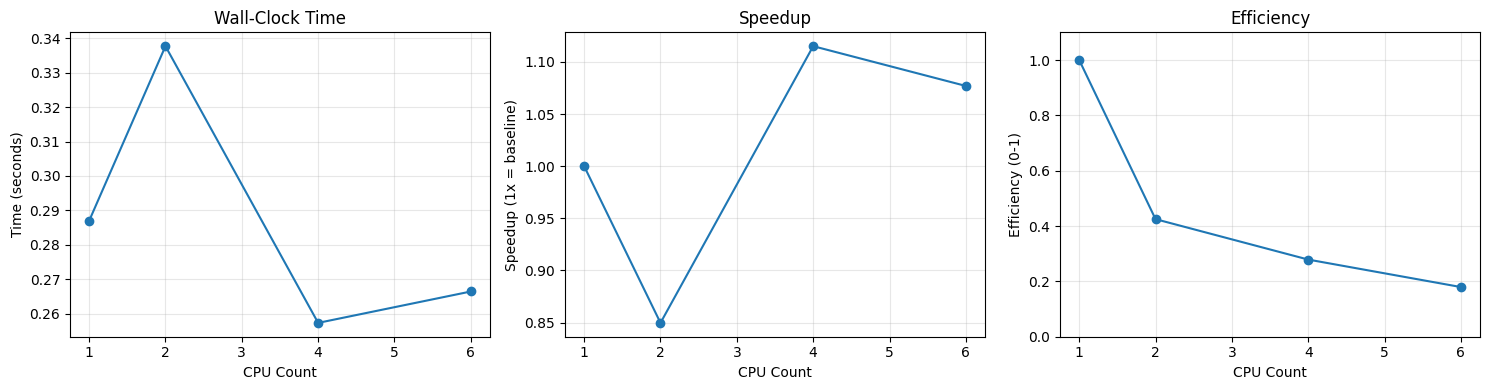

In [3]:
# --- Configuration ---
DATA_DIR = 'Data'  # Root directory
CPU_COUNTS = [1, 2, 4, 6]
OUTPUT_FILENAME = 'oral_cancer_dataset.csv'

# --- Worker Function ---
def process_file_path(filepath):
    """
    Worker function to process a single file path.
    Extracts ID and assigns Label based on folder structure.
    """
    # Extract ID (filename)
    file_id = os.path.basename(filepath)
    
    # Extract Label based on parent folder name
    # Logic: Check if 'Normal' or 'OSCC' exists in the path
    if 'Normal' in filepath:
        label = 0
    elif 'OSCC' in filepath:
        label = 1
    else:
        label = -1 # Error case
        
    return {'id': file_id, 'label': label}

def run_benchmark(file_list, num_cpus):
    """
    Runs the processing task using a specific number of CPUs.
    Returns the time taken and the resulting dataframe.
    """
    start_time = time.time()
    
    if num_cpus == 1:
        # Serial processing
        results = [process_file_path(f) for f in file_list]
    else:
        # Parallel processing
        with multiprocessing.Pool(processes=num_cpus) as pool:
            results = pool.map(process_file_path, file_list)
            
    end_time = time.time()
    
    df = pd.DataFrame(results)
    return end_time - start_time, df

# --- Main Execution Block ---
if __name__ == '__main__':
    # 1. Gather all file paths
    print("Gathering file paths...")
    all_files = glob.glob(os.path.join(DATA_DIR, '**', '*.jpg'), recursive=True)
    
    # Filter:
    # 1. Must contain 'Normal' or 'OSCC'
    # 2. Must NOT contain 'val'
    all_files = [
        f for f in all_files 
        if ('Normal' in f or 'OSCC' in f) and 'val' not in f
    ]
    
    print(f"Found {len(all_files)} images (excluding 'val').")

    # 2. Benchmark Loop
    timings = []
    final_df = None

    print(f"\nStarting Benchmark on {CPU_COUNTS} CPUs...")
    print("-" * 30)

    for count in CPU_COUNTS:
        duration, df = run_benchmark(all_files, count)
        timings.append(duration)
        final_df = df 
        print(f"{count} CPU(s): {duration:.4f} seconds")

    # 3. Save the CSV
    if final_df is not None:
        final_df.to_csv(OUTPUT_FILENAME, index=False)
        print(f"\nCSV saved to {OUTPUT_FILENAME}")
        print(final_df.head())

    # 4. Calculate Speedup and Efficiency
    base_time = timings[0]
    speedups = [base_time / t for t in timings]
    efficiencies = [s / c for s, c in zip(speedups, CPU_COUNTS)]

    # 5. Plotting
    plt.figure(figsize=(15, 4))

    # Plot 1: Wall-Clock Time
    plt.subplot(1, 3, 1)
    plt.plot(CPU_COUNTS, timings, marker='o')
    plt.title("Wall-Clock Time")
    plt.xlabel("CPU Count")
    plt.ylabel("Time (seconds)")
    plt.grid(True, alpha=0.3)

    # Plot 2: Speedup
    plt.subplot(1, 3, 2)
    plt.plot(CPU_COUNTS, speedups, marker='o')
    plt.title("Speedup")
    plt.xlabel("CPU Count")
    plt.ylabel("Speedup (1x = baseline)")
    plt.grid(True, alpha=0.3)

    # Plot 3: Efficiency
    plt.subplot(1, 3, 3)
    plt.plot(CPU_COUNTS, efficiencies, marker='o')
    plt.title("Efficiency")
    plt.xlabel("CPU Count")
    plt.ylabel("Efficiency (0-1)")
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## Dask Implementation to create Oral Cancer Dataset

Gathering file paths...
Found 287832 images (excluding 'val').

Starting Dask Benchmark on [1, 2, 4, 6] CPUs...
------------------------------
   [Dask] Processing with 1 CPUs...
1 CPU(s): 2.1997 seconds
   [Dask] Processing with 2 CPUs...
2 CPU(s): 1.5805 seconds
   [Dask] Processing with 4 CPUs...
4 CPU(s): 1.3762 seconds
   [Dask] Processing with 6 CPUs...
6 CPU(s): 1.3418 seconds

CSV saved to oral_cancer_dataset_dask.csv


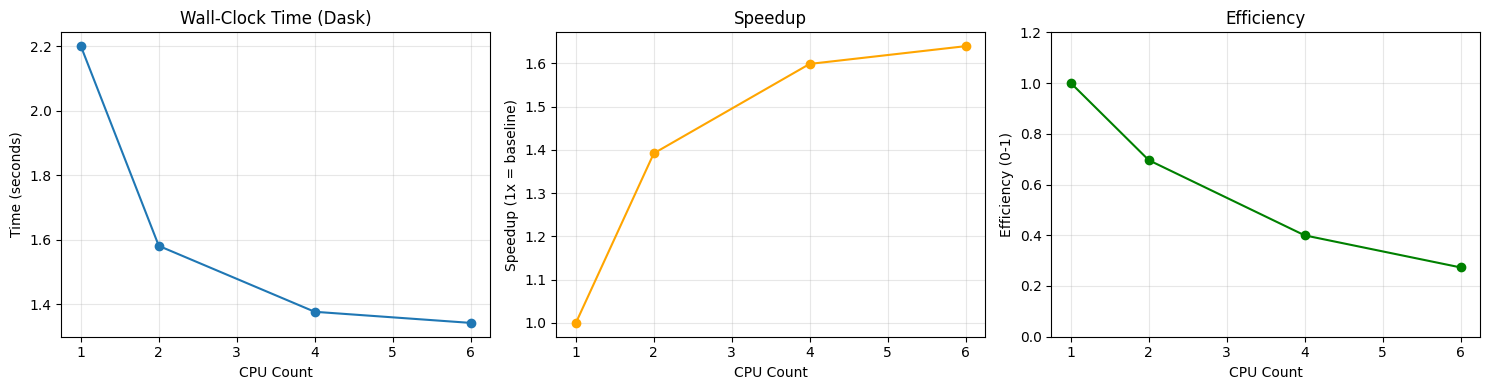

In [4]:
# --- Configuration ---
DATA_DIR = 'Data'
CPU_COUNTS = [1, 2, 4, 6]
OUTPUT_FILENAME = 'oral_cancer_dataset_dask.csv'

# --- Worker Function ---
def process_file_path(filepath):
    # (Same logic as before)
    file_id = os.path.basename(filepath)
    if 'Normal' in filepath:
        label = 0
    elif 'OSCC' in filepath:
        label = 1
    else:
        label = -1
    return {'id': file_id, 'label': label}

def run_benchmark_dask(file_list, num_cpus):
    print(f"   [Dask] Processing with {num_cpus} CPUs...")
    start_time = time.time()
    
    # 1. Create a Dask Bag from the list
    # npartitions determines how the work is split. 
    # Using a multiple of num_cpus is usually good for load balancing.
    bag = db.from_sequence(file_list, npartitions=num_cpus * 4)
    
    # 2. Map the function (Lazy)
    # This prepares the computation graph but doesn't run it yet
    mapped_bag = bag.map(process_file_path)
    
    # 3. Compute (Trigger Execution)
    # scheduler='processes' ensures we use multiple CPU cores (bypassing GIL)
    results = mapped_bag.compute(scheduler='processes', num_workers=num_cpus)
            
    end_time = time.time()
    df = pd.DataFrame(results)
    return end_time - start_time, df

# --- Main Execution Block ---
if __name__ == '__main__':
    # 1. Gather files
    print("Gathering file paths...")
    all_files = glob.glob(os.path.join(DATA_DIR, '**', '*.jpg'), recursive=True)
    all_files = [f for f in all_files if ('Normal' in f or 'OSCC' in f) and 'val' not in f]
    print(f"Found {len(all_files)} images (excluding 'val').")

    # 2. Benchmark Loop
    timings = []
    final_df = None

    print(f"\nStarting Dask Benchmark on {CPU_COUNTS} CPUs...")
    print("-" * 30)

    for count in CPU_COUNTS:
        duration, df = run_benchmark_dask(all_files, count)
        timings.append(duration)
        final_df = df
        print(f"{count} CPU(s): {duration:.4f} seconds")

    # 3. Save CSV
    if final_df is not None:
        final_df.to_csv(OUTPUT_FILENAME, index=False)
        print(f"\nCSV saved to {OUTPUT_FILENAME}")

    # 4. Calculations & Plotting
    base_time = timings[0]
    speedups = [base_time / t for t in timings]
    efficiencies = [s / c for s, c in zip(speedups, CPU_COUNTS)]

    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(CPU_COUNTS, timings, marker='o')
    plt.title("Wall-Clock Time (Dask)")
    plt.xlabel("CPU Count")
    plt.ylabel("Time (seconds)")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(CPU_COUNTS, speedups, marker='o', color='orange')
    plt.title("Speedup")
    plt.xlabel("CPU Count")
    plt.ylabel("Speedup (1x = baseline)")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(CPU_COUNTS, efficiencies, marker='o', color='green')
    plt.title("Efficiency")
    plt.xlabel("CPU Count")
    plt.ylabel("Efficiency (0-1)")
    plt.ylim(0, 1.2)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## JobLib Implementation to create Oral Cancer Dataset

Gathering file paths...
Found 287832 images (excluding 'val').

Starting Joblib Benchmark on [1, 2, 4, 6] CPUs...
------------------------------
   [Joblib] Processing with 1 CPUs...
1 CPU(s): 1.0833 seconds
   [Joblib] Processing with 2 CPUs...
2 CPU(s): 1.7357 seconds
   [Joblib] Processing with 4 CPUs...
4 CPU(s): 1.5964 seconds
   [Joblib] Processing with 6 CPUs...
6 CPU(s): 1.3522 seconds

CSV saved to oral_cancer_dataset_joblib.csv


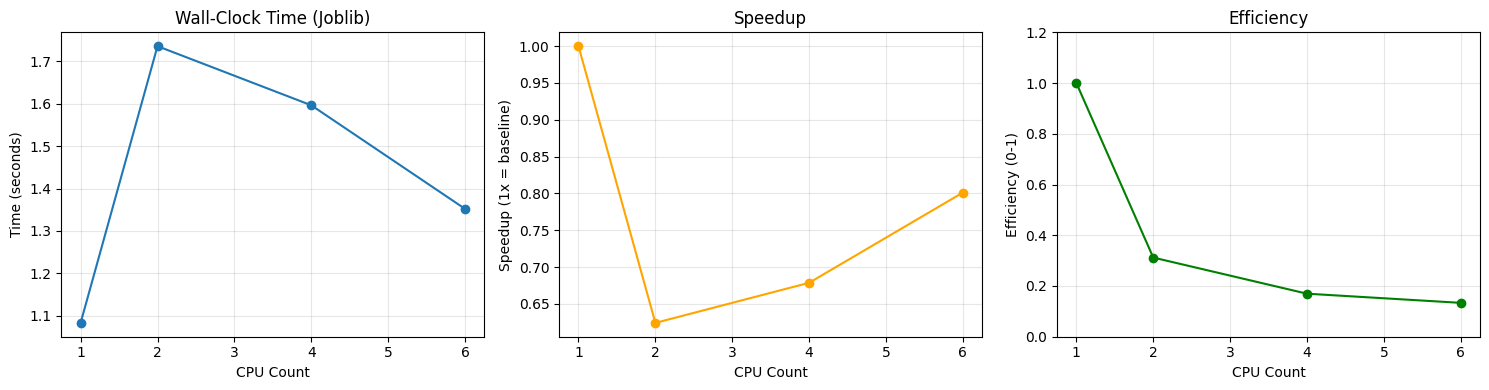

In [5]:
# --- Configuration ---
DATA_DIR = 'Data'
CPU_COUNTS = [1, 2, 4, 6]
OUTPUT_FILENAME = 'oral_cancer_dataset_joblib.csv'

# --- Worker Function ---
def process_file_path(filepath):
    """
    Worker function to process a single file path.
    """
    file_id = os.path.basename(filepath)
    
    if 'Normal' in filepath:
        label = 0
    elif 'OSCC' in filepath:
        label = 1
    else:
        label = -1
        
    return {'id': file_id, 'label': label}

def run_benchmark_joblib(file_list, num_cpus):
    print(f"   [Joblib] Processing with {num_cpus} CPUs...")
    start_time = time.time()
    
    # Joblib Parallel Execution
    # n_jobs sets the number of workers. backend='loky' is default and robust.
    results = Parallel(n_jobs=num_cpus)(
        delayed(process_file_path)(f) for f in file_list
    )
            
    end_time = time.time()
    df = pd.DataFrame(results)
    return end_time - start_time, df

# --- Main Execution Block ---
if __name__ == '__main__':
    # 1. Gather files
    print("Gathering file paths...")
    all_files = glob.glob(os.path.join(DATA_DIR, '**', '*.jpg'), recursive=True)
    
    # Apply your specific filters
    all_files = [
        f for f in all_files 
        if ('Normal' in f or 'OSCC' in f) and 'val' not in f
    ]
    print(f"Found {len(all_files)} images (excluding 'val').")

    # 2. Benchmark Loop
    timings = []
    final_df = None

    print(f"\nStarting Joblib Benchmark on {CPU_COUNTS} CPUs...")
    print("-" * 30)

    for count in CPU_COUNTS:
        duration, df = run_benchmark_joblib(all_files, count)
        timings.append(duration)
        final_df = df
        print(f"{count} CPU(s): {duration:.4f} seconds")

    # 3. Save CSV
    if final_df is not None:
        final_df.to_csv(OUTPUT_FILENAME, index=False)
        print(f"\nCSV saved to {OUTPUT_FILENAME}")

    # 4. Calculate Speedup and Efficiency
    base_time = timings[0]
    speedups = [base_time / t for t in timings]
    efficiencies = [s / c for s, c in zip(speedups, CPU_COUNTS)]

    # 5. Plotting
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(CPU_COUNTS, timings, marker='o')
    plt.title("Wall-Clock Time (Joblib)")
    plt.xlabel("CPU Count")
    plt.ylabel("Time (seconds)")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(CPU_COUNTS, speedups, marker='o', color='orange')
    plt.title("Speedup")
    plt.xlabel("CPU Count")
    plt.ylabel("Speedup (1x = baseline)")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(CPU_COUNTS, efficiencies, marker='o', color='green')
    plt.title("Efficiency")
    plt.xlabel("CPU Count")
    plt.ylabel("Efficiency (0-1)")
    plt.ylim(0, 1.2)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [6]:
# The CPU counts used for the benchmarks
cpu_counts_run = [1, 2, 4, 6] 

# Timings from your output logs
# [1 CPU, 2 CPUs, 4 CPUs, 6 CPUs]
regular_times = [0.2870, 0.3377, 0.2573, 0.2665] 
dask_times    = [2.1997, 1.5805, 1.3762, 1.3418]
joblib_times  = [1.0833, 1.7357, 1.5964, 1.3522]


# Identify "Sequential" Baseline (Regular 1 CPU)

seq_time = regular_times[0] 


# Finding "Best" (Fastest) Run for Each Framework
# Helper to find index of min value
def get_best_idx(times):
    return times.index(min(times))

best_reg_idx    = get_best_idx(regular_times)
best_joblib_idx = get_best_idx(joblib_times)
best_dask_idx   = get_best_idx(dask_times)


# Constructing the Data Table
data = []

# Sequential Baseline
data.append({
    "Framework": "Sequential (1 CPU)",
    "Best CPUs": 1,
    "Time (s)": seq_time,
    "Speedup": 1.0
})

# Regular Multiprocessing
reg_best_time = regular_times[best_reg_idx]
data.append({
    "Framework": "Regular MP (Best)",
    "Best CPUs": cpu_counts_run[best_reg_idx],
    "Time (s)": reg_best_time,
    "Speedup": seq_time / reg_best_time
})

# Joblib
joblib_best_time = joblib_times[best_joblib_idx]
data.append({
    "Framework": "Joblib (Best)",
    "Best CPUs": cpu_counts_run[best_joblib_idx],
    "Time (s)": joblib_best_time,
    "Speedup": seq_time / joblib_best_time
})

# Dask
dask_best_time = dask_times[best_dask_idx]
data.append({
    "Framework": "Dask (Best)",
    "Best CPUs": cpu_counts_run[best_dask_idx],
    "Time (s)": dask_best_time,
    "Speedup": seq_time / dask_best_time
})

# Create and Display DataFrame

df_summary = pd.DataFrame(data)

# Sorting by Time (Fastest on top)
df_summary = df_summary.sort_values(by="Time (s)")

print("Performance Comparison Table:")
print("-" * 60)
print(df_summary.to_string(index=False, formatters={
    'Time (s)': '{:.4f}'.format,
    'Speedup': '{:.2f}x'.format
}))
print("-" * 60)

Performance Comparison Table:
------------------------------------------------------------
         Framework  Best CPUs Time (s) Speedup
 Regular MP (Best)          4   0.2573   1.12x
Sequential (1 CPU)          1   0.2870   1.00x
     Joblib (Best)          1   1.0833   0.26x
       Dask (Best)          6   1.3418   0.21x
------------------------------------------------------------


## Reading CSV file

In [4]:
# 1. Read the CSV file
df = pd.read_csv('oral_cancer_dataset.csv')

# 2. Count the occurrences in the 'label' column
counts = df['label'].value_counts()

# 3. Print the results
print("Dataset Distribution:")
print("-" * 25)
print(f"Normal (0): {counts.get(0, 0)} images")
print(f"Cancer (1): {counts.get(1, 0)} images")
print("-" * 25)
print(f"Total     : {len(df)} images")

Dataset Distribution:
-------------------------
Normal (0): 143846 images
Cancer (1): 143986 images
-------------------------
Total     : 287832 images


In [5]:
len(df['id'].unique())

240705

## Removing Duplicates

In [20]:
# 1. Read the existing CSV file
df = pd.read_csv('oral_cancer_dataset.csv')
print(f"Original Row Count: {len(df)}")

# 2. Remove duplicates
# subset='id' ensures we look for duplicate filenames
# keep='first' keeps the first occurrence and removes subsequent ones
df_clean = df.drop_duplicates(subset='id', keep='first')

# 3. Save the cleaned data back to CSV
# (You can overwrite the original by changing the filename below to 'oral_cancer_dataset.csv')
cleaned_filename = 'oral_cancer_dataset_cleaned.csv'
df_clean.to_csv(cleaned_filename, index=False)
print(f"Duplicates removed. Saved to {cleaned_filename}")

# 4. Recount the occurrences in the cleaned data
counts = df_clean['label'].value_counts()

print("\nDataset Distribution (Cleaned):")
print("-" * 25)
print(f"Normal (0): {counts.get(0, 0)} images")
print(f"Cancer (1): {counts.get(1, 0)} images")
print("-" * 25)
print(f"Total     : {len(df_clean)} images")

Original Row Count: 287832
Duplicates removed. Saved to oral_cancer_dataset_cleaned.csv

Dataset Distribution (Cleaned):
-------------------------
Normal (0): 120283 images
Cancer (1): 120422 images
-------------------------
Total     : 240705 images


In [7]:
len(df_clean['id'].unique())

240705

# Visualization

In [8]:
import seaborn as sns
sns.set()

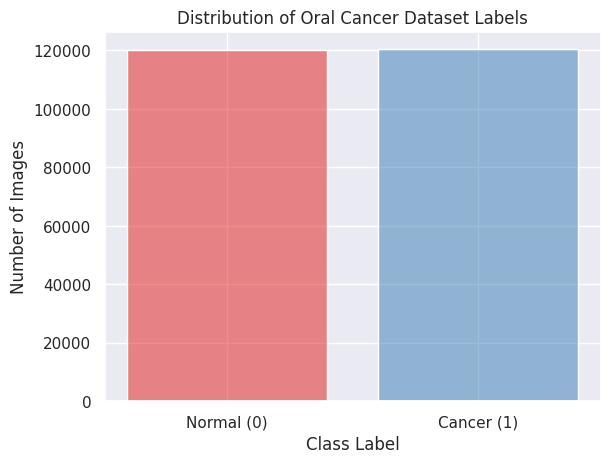

In [9]:
# Load your dataset
df_clean = pd.read_csv('oral_cancer_dataset_cleaned.csv')

# plt.figure(figsize=(8, 6))

# Create the histogram
# discrete=True ensures the bars are centered on the integers 0 and 1
# shrink=0.8 adds some space between bars for better visibility
sns.histplot(data=df_clean, x='label', hue='label', discrete=True, legend=False, shrink=0.8, palette='Set1')

# Add custom labels for clarity
plt.xticks([0, 1], ['Normal (0)', 'Cancer (1)'])
plt.title('Distribution of Oral Cancer Dataset Labels')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')

# Save and Show
plt.savefig('label_distribution.png')
plt.show()

In [11]:
from PIL import Image
import glob

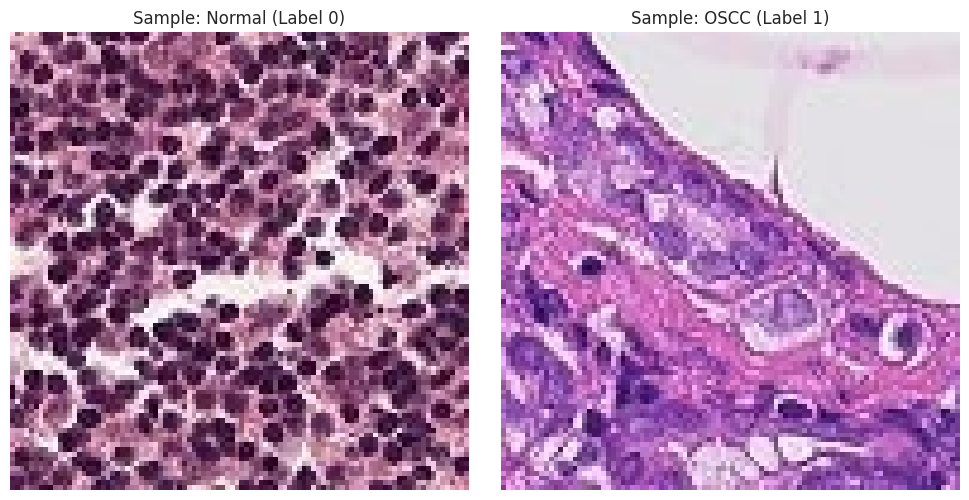

Displayed Normal: Data/test/Normal/0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.jpg
Displayed OSCC:   Data/test/OSCC/00014e39b5df5f80df56f18a0a049d1cc6de430a.jpg


In [14]:
# Define our data directory
DATA_DIR = 'Data' 

# 1. Find one image for each class
# We prefer the 'train' folder, but use recursive search just in case
normal_files = glob.glob(os.path.join(DATA_DIR, '**', 'Normal', '*.jpg'), recursive=True)
oscc_files = glob.glob(os.path.join(DATA_DIR, '**', 'OSCC', '*.jpg'), recursive=True)

# Check if we found images
if normal_files and oscc_files:
    # Pick the first one from each list
    normal_img_path = normal_files[0]
    oscc_img_path = oscc_files[0]

    # 2. Setup the plot (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- Display Normal Image ---
    img_normal = Image.open(normal_img_path)
    axes[0].imshow(img_normal)
    axes[0].set_title("Sample: Normal (Label 0)")
    axes[0].axis('off')

    # --- Display OSCC Image ---
    img_oscc = Image.open(oscc_img_path)
    axes[1].imshow(img_oscc)
    axes[1].set_title("Sample: OSCC (Label 1)")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    
    # Optional: Print the paths being displayed
    print(f"Displayed Normal: {normal_img_path}")
    print(f"Displayed OSCC:   {oscc_img_path}")

else:
    print("Error: Could not find images in the 'Normal' or 'OSCC' folders.")

## 3x3 For Normal

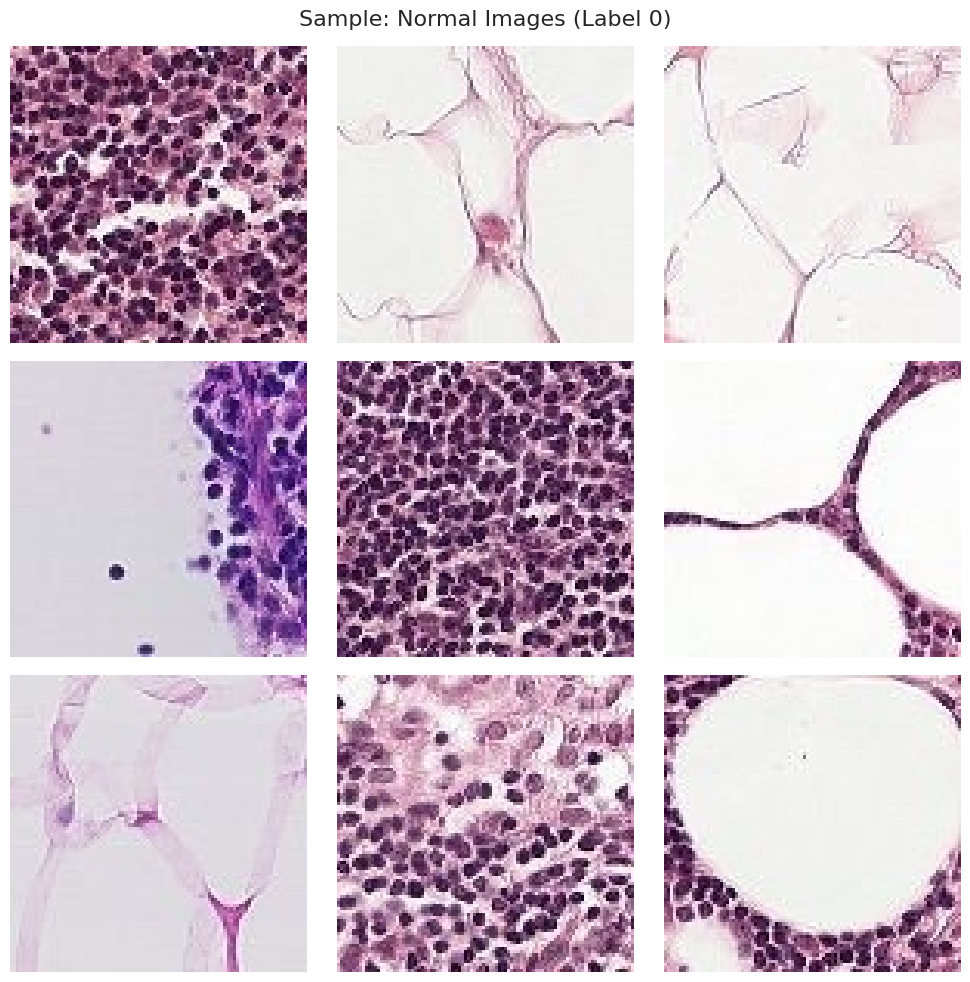

In [15]:
# Efficiently find exactly 9 Normal images
normal_images = []
for root, dirs, files in os.walk(DATA_DIR):
    if 'Normal' in root and 'val' not in root: # Ensure we are in a Normal folder
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                normal_images.append(os.path.join(root, file))
                if len(normal_images) == 9: # Stop once we have 9
                    break
    if len(normal_images) == 9:
        break

# Plotting
if len(normal_images) == 9:
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle('Sample: Normal Images (Label 0)', fontsize=16)

    for i, ax in enumerate(axes.flat):
        img = Image.open(normal_images[i])
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough images found. Found {len(normal_images)}")

## 3x3 for OSCC

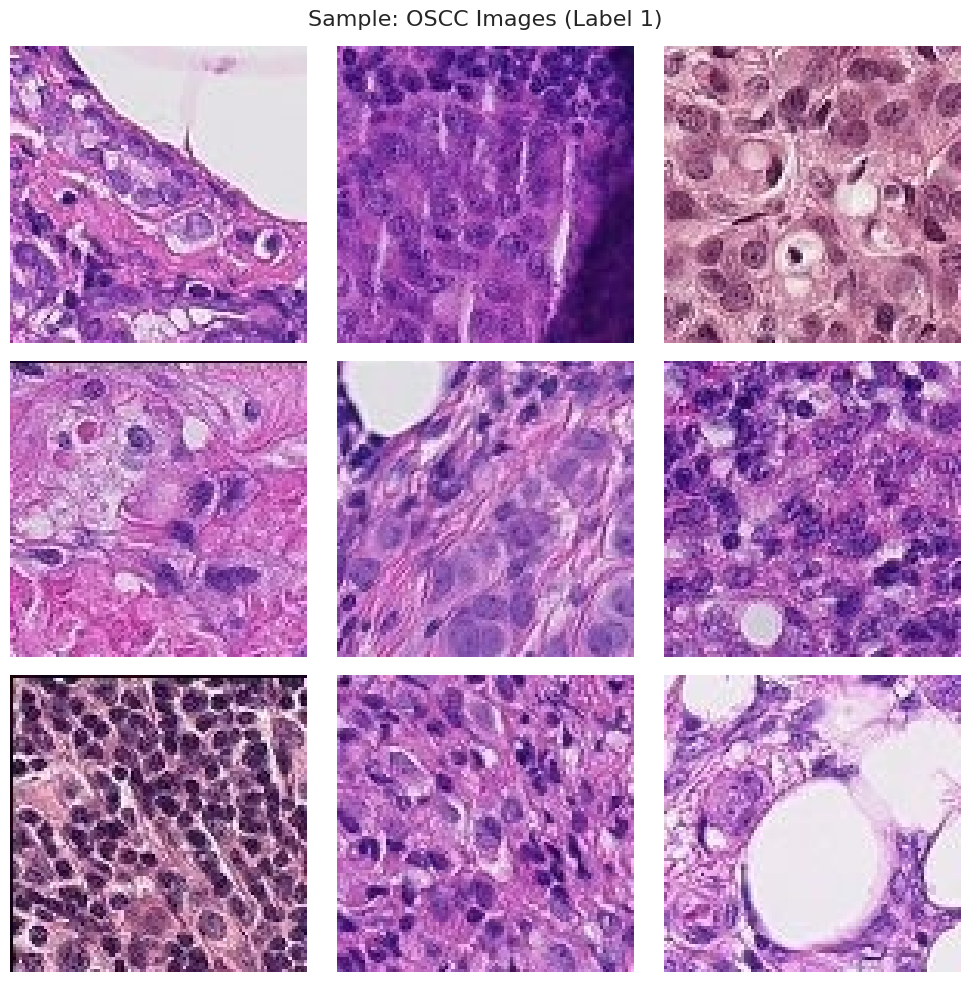

In [16]:
# Efficiently find exactly 9 OSCC images
oscc_images = []
for root, dirs, files in os.walk(DATA_DIR):
    if 'OSCC' in root and 'val' not in root: # Ensure we are in an OSCC folder
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                oscc_images.append(os.path.join(root, file))
                if len(oscc_images) == 9: # Stop once we have 9
                    break
    if len(oscc_images) == 9:
        break

# Plotting
if len(oscc_images) == 9:
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle('Sample: OSCC Images (Label 1)', fontsize=16)

    for i, ax in enumerate(axes.flat):
        img = Image.open(oscc_images[i])
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough images found. Found {len(oscc_images)}")

In [19]:
# Use one of the paths we found earlier
img = Image.open(normal_images[0])

# .size returns a tuple (width, height)
width, height = img.size

print(f"Dimensions: {width} x {height} pixels")
print(f"Mode: {img.mode}") # e.g., 'RGB' or 'L' (grayscale)

Dimensions: 96 x 96 pixels
Mode: RGB


### Verifying if all images are 96x96

In [18]:
samples_to_check = 100
checked = 0

print(f"Checking {samples_to_check} random images...")

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg')):
            path = os.path.join(root, file)
            with Image.open(path) as img:
                if img.size != (96, 96):
                    print(f"WARNING: Found mismatch! {path} is {img.size}")
            
            checked += 1
            if checked >= samples_to_check:
                break
    if checked >= samples_to_check:
        break

print("Check complete.")

Checking 100 random images...
Check complete.


# Creating the Balanced Dataset

Loaded 240705 rows.

Starting Benchmark...
------------------------------
1 CPU(s): 0.0615 seconds
2 CPU(s): 0.2894 seconds
4 CPU(s): 0.2376 seconds
6 CPU(s): 0.2511 seconds


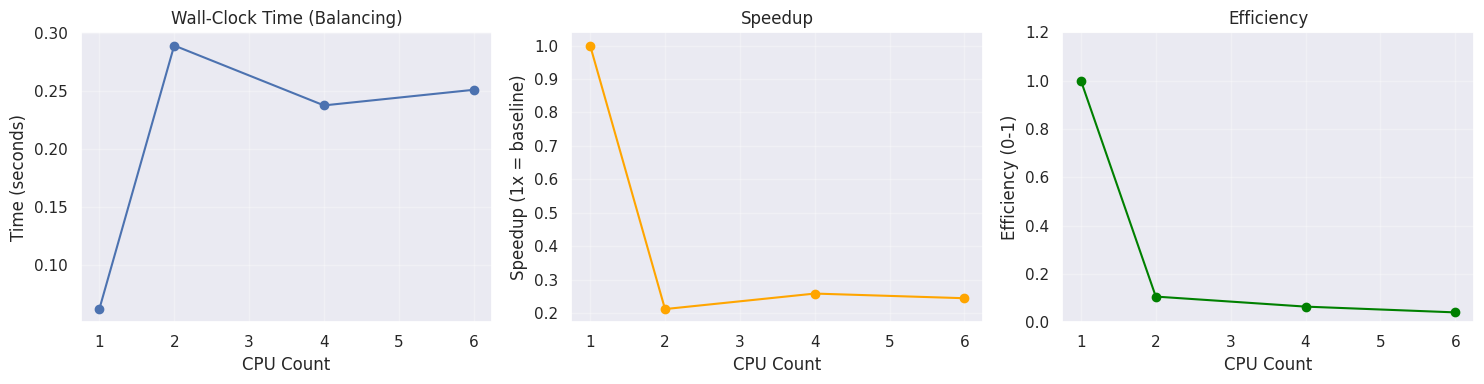

In [23]:


# # --- Configuration ---
CPU_COUNTS = [1, 2, 4, 6]
RANDOM_STATE = 102

# --- Worker Function ---
def parallel_filter(df_chunk):
    """
    Worker function: Receives a chunk of data, 
    separates it into Normal and Cancer dataframes locally.
    """
    # Filter locally
    chunk_normal = df_chunk[df_chunk['label'] == 0]
    chunk_cancer = df_chunk[df_chunk['label'] == 1]
    return chunk_normal, chunk_cancer

# --- Main Benchmark Logic ---
def run_balancing_benchmark(df, num_cpus):
    start_time = time.time()
    
    if num_cpus == 1:
        # --- Serial Implementation (Standard Pandas) ---
        min_class_size = df['label'].value_counts().min()
        
        df_normal = df[df['label'] == 0]
        df_cancer = df[df['label'] == 1]
        
        df_normal_balanced = df_normal.sample(n=min_class_size, random_state=RANDOM_STATE)
        df_cancer_balanced = df_cancer.sample(n=min_class_size, random_state=RANDOM_STATE)
        
        df_final = pd.concat([df_normal_balanced, df_cancer_balanced])
        df_final = df_final.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        
    else:
        # --- Parallel Implementation ---
        # 1. Split the main dataframe into chunks
        df_chunks = np.array_split(df, num_cpus)
        
        # 2. Parallel Processing: Filter chunks
        with multiprocessing.Pool(processes=num_cpus) as pool:
            results = pool.map(parallel_filter, df_chunks)
        
        # 3. Gather Results
        # results is a list of tuples: [(norm1, canc1), (norm2, canc2), ...]
        all_normals = [res[0] for res in results]
        all_cancers = [res[1] for res in results]
        
        # 4. Concatenate back to two main groups
        df_normal = pd.concat(all_normals)
        df_cancer = pd.concat(all_cancers)
        
        # 5. Calculate Min Size (Must be done globally)
        min_class_size = min(len(df_normal), len(df_cancer))
        
        # 6. Sample (Sampling is difficult to parallelize exactly without bias, so we do it serially here)
        df_normal_balanced = df_normal.sample(n=min_class_size, random_state=RANDOM_STATE)
        df_cancer_balanced = df_cancer.sample(n=min_class_size, random_state=RANDOM_STATE)
        
        # 7. Final Concatenate and Shuffle
        df_final = pd.concat([df_normal_balanced, df_cancer_balanced])
        df_final = df_final.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    end_time = time.time()
    return end_time - start_time, df_final

# --- Execution Block ---
if __name__ == '__main__':
    # # 1. Load Data
    # print(f"Loading {INPUT_FILENAME}...")
    # df_clean = pd.read_csv(INPUT_FILENAME)
    print(f"Loaded {len(df_clean)} rows.")

    timings = []
    
    # 2. Benchmark Loop
    print("\nStarting Benchmark...")
    print("-" * 30)
    for count in CPU_COUNTS:
        duration, _ = run_balancing_benchmark(df_clean, count)
        timings.append(duration)
        print(f"{count} CPU(s): {duration:.4f} seconds")

    # 3. Calculations
    base_time = timings[0]
    speedups = [base_time / t for t in timings]
    efficiencies = [s / c for s, c in zip(speedups, CPU_COUNTS)]

    # 4. Plotting
    plt.figure(figsize=(15, 4))

    # Wall-Clock Time
    plt.subplot(1, 3, 1)
    plt.plot(CPU_COUNTS, timings, marker='o')
    plt.title("Wall-Clock Time (Balancing)")
    plt.xlabel("CPU Count")
    plt.ylabel("Time (seconds)")
    plt.grid(True, alpha=0.3)

    # Speedup
    plt.subplot(1, 3, 2)
    plt.plot(CPU_COUNTS, speedups, marker='o', color='orange')
    plt.title("Speedup")
    plt.xlabel("CPU Count")
    plt.ylabel("Speedup (1x = baseline)")
    plt.grid(True, alpha=0.3)

    # Efficiency
    plt.subplot(1, 3, 3)
    plt.plot(CPU_COUNTS, efficiencies, marker='o', color='green')
    plt.title("Efficiency")
    plt.xlabel("CPU Count")
    plt.ylabel("Efficiency (0-1)")
    plt.ylim(0, 1.2)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [25]:
# 5. Verify the result
print("\nFinal Balanced Distribution:")
print(df_final['label'].value_counts())


Final Balanced Distribution:
label
1    120283
0    120283
Name: count, dtype: int64


In [26]:
df_final.to_csv('oral_cancer_balanced.csv', index=False)

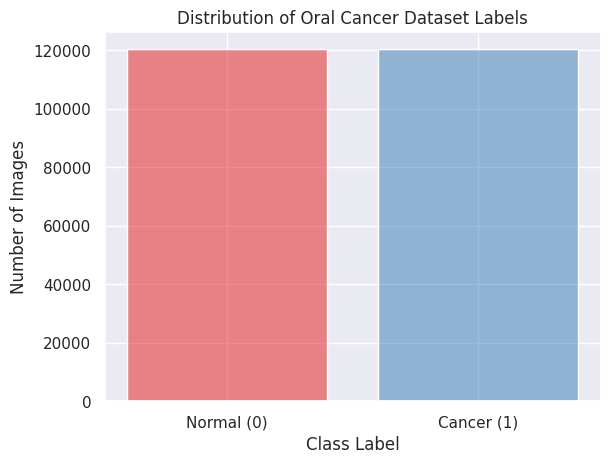

In [27]:
# Load your dataset
df_clean = pd.read_csv('oral_cancer_balanced.csv')

# plt.figure(figsize=(8, 6))

# Create the histogram
# discrete=True ensures the bars are centered on the integers 0 and 1
# shrink=0.8 adds some space between bars for better visibility
sns.histplot(data=df_clean, x='label', hue='label', discrete=True, legend=False, shrink=0.8, palette='Set1')

# Add custom labels for clarity
plt.xticks([0, 1], ['Normal (0)', 'Cancer (1)'])
plt.title('Distribution of Oral Cancer Dataset Labels')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')

# Save and Show
plt.savefig('label_distribution.png')
plt.show()